# Import Neccessary Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import math
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset

In [2]:
# load dataset
prop = pd.read_csv('./Properties.csv')
prop.head()

,page,title,description,bedrooms,bathrooms,toilets,garage,location,city,price
0,1,An Exquisite And Luxurious 3 Bedroom Apartment,3 bedroom flat / apartment for rent,3,3,4,3,"Ikoyi, Lagos",Ikoyi,15000000
1,1,2bedroom Apartment,2 bedroom flat / apartment for rent,2,2,3,0,"Oniru, Oniru, Victoria Island (VI), Lagos",Victoria Island,3500000
2,1,Executive 3 Bedroom Flat Serviced Apartment,3 bedroom flat / apartment for rent,3,3,3,2,"Prime Water Garden, Ikate, Lekki, Lagos",Lekki,4000000
3,1,Fantastic 1 Bedroom Mini Flat,1 bedroom mini flat (room and parlour) for rent,1,1,1,0,"Lekki Palm City, Ajah, Lagos",Ajah,1000000
4,1,Luxury,4 bedroom flat / apartment for rent,4,3,4,0,"Old Ikoyi, Ikoyi, Lagos",Ikoyi,12000000


In [3]:
prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6573 entries, 0 to 6572
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   page         6573 non-null   int64 
 1   title        6573 non-null   object
 2   description  6573 non-null   object
 3   bedrooms     6573 non-null   int64 
 4   bathrooms    6573 non-null   int64 
 5   toilets      6573 non-null   int64 
 6   garage       6573 non-null   int64 
 7   location     6573 non-null   object
 8   city         6573 non-null   object
 9   price        6573 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 513.6+ KB


In [4]:
prop.describe()

,page,bedrooms,bathrooms,toilets,garage,price
count,6573.00000,6573.000000,6573.000000,6573.000000,6573.000000,6.573000e+03
mean,157.00000,2.139814,2.251331,2.801156,1.665906,1.065897e+07
std,90.36173,1.135422,1.069752,1.368785,1.771843,2.820651e+08
min,1.00000,0.000000,1.000000,1.000000,0.000000,2.500000e+04
25%,79.00000,1.000000,1.000000,1.000000,0.000000,1.000000e+06
50%,157.00000,2.000000,2.000000,3.000000,2.000000,2.000000e+06
75%,235.00000,3.000000,3.000000,4.000000,2.000000,5.000000e+06
max,313.00000,8.000000,8.000000,9.000000,9.000000,1.500000e+10


In [5]:
# Checking for missing values
prop.isnull().sum() * 100 / len(prop)

page           0.0
title          0.0
description    0.0
bedrooms       0.0
bathrooms      0.0
toilets        0.0
garage         0.0
location       0.0
city           0.0
price          0.0
dtype: float64

# Data Cleaning and Exploration

In [6]:
# Checking for unique cities
prop['city'].unique()

array(['Ikoyi', 'Victoria Island', 'Lekki', 'Ajah', 'North', 'Maryland',
       'Yaba', 'Ogudu', 'Ikeja', 'Ikorodu', 'Shomolu', 'Gbagada',
       'Magodo', 'Ilupeju', 'Surulere', 'Ketu', 'Odofin', 'Ojodu',
       'Ojota', 'Kosofe', 'Agege', 'Isolo', 'Mushin', 'Ijede', 'Ayobo',
       'Ipaja', 'Ikotun', 'Eko Atlantic City', 'Alimosho', 'Ojo',
       'Ifako-Ijaiye', 'Ijaiye', 'Epe', 'Island', 'Oshodi', 'Idimu',
       'Apapa'], dtype=object)

In [7]:
# Renaming some cities properly to aid our prediciton perform better
prop['city'].replace('North', 'Isheri North', inplace=True)
prop['city'].replace('Island', 'Lagos Island', inplace=True)

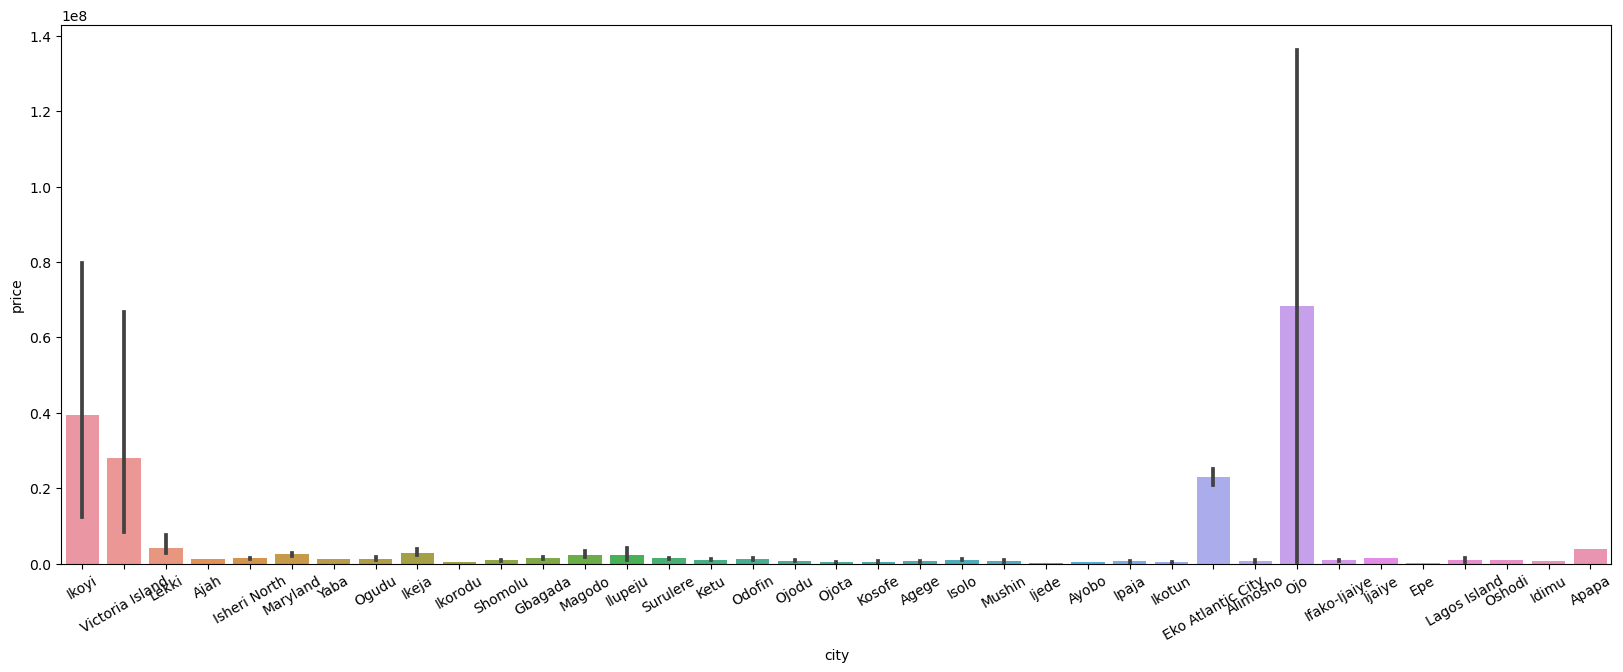

In [8]:
plt.figure(figsize=(20,7))
ax = sns.barplot(x='city',y='price', data=prop)
plt.xticks(rotation=30);

In [9]:
prop.head(2)

,page,title,description,bedrooms,bathrooms,toilets,garage,location,city,price
0,1,An Exquisite And Luxurious 3 Bedroom Apartment,3 bedroom flat / apartment for rent,3,3,4,3,"Ikoyi, Lagos",Ikoyi,15000000
1,1,2bedroom Apartment,2 bedroom flat / apartment for rent,2,2,3,0,"Oniru, Oniru, Victoria Island (VI), Lagos",Victoria Island,3500000


## Performing Some Feature Engineering

In [10]:
# Creating island features of places from location columns 
def island_flag(prop):
    if (prop['city']=='Lekki') or (prop['city']=='Victoria Island') or (prop['city']=='Ajah') \
     or (prop['city']=='Ikoyi') or (prop['city']=='Eko Atlantic City') \
    or (prop['city']=='Epe') or (prop['city']=='Lagos Island'):
        return 1
    else:
        return 0

In [11]:
# Create Island features
prop['island_flag'] = prop.apply(island_flag, axis=1)

In [12]:
prop['island_flag'].value_counts()

1    5175
0    1398
Name: island_flag, dtype: int64

In [13]:
# Create Estate feature
prop['estate_flag'] = prop['location'].apply(lambda x: len([c for c in str(x).lower().split() if "estate" in c]))

# Create terrace/duplex/detached houses feature
prop['terrace_flag'] = prop['title'].apply(lambda x: len([c for c in str(x).lower().split() if "terraced" 
                                                          in c or "terrace" in c or "detached" in c
                                                                 or "duplex" in c]))

# Create new/renovated houses feature
prop['new_flag'] = prop['title'].apply(lambda x: len([c for c in str(x).lower().split()
                                                              if "new" in c or "newly" in c or "renovated" in c]))

# Create luxurious/executive/exquisite houses feature
prop['luxury_flag'] = prop['title'].apply(lambda x: len([c for c in str(x).lower().split()
                                                              if "luxury" in c or "executive" in c or "luxurious" in c
                                                        or "exquisite"in c or "excellent" in c]))

# Create Serviced houses feature
prop['serviced_flag'] = prop['title'].apply(lambda x: len([c for c in str(x).lower().split()
                                                                           if "serviced" in c]))

# Create studio apartment feature
prop['studio_flag'] = prop['title'].apply(lambda x: len([c for c in str(x).lower().split()
                                                                           if "studio" in c]))

# Create big/spacious houses feature
prop['big_flag'] = prop['title'].apply(lambda x: len([c for c in str(x).lower().split() if "spacious" in c
                                                     or "big" in c]))

# Create self-contain houses feature
prop['selfcontain_flag'] = prop['description'].apply(lambda x: len([c for c in str(x).lower().split() if "self" in c]))


# Create flat feature
prop['flat_flag'] = prop['description'].apply(lambda x: len([c for c in str(x).lower().split() if "flat" in c]))

In [14]:
prop.head(2)

,page,title,description,bedrooms,bathrooms,toilets,garage,location,city,price,island_flag,estate_flag,terrace_flag,new_flag,luxury_flag,serviced_flag,studio_flag,big_flag,selfcontain_flag,flat_flag
0,1,An Exquisite And Luxurious 3 Bedroom Apartment,3 bedroom flat / apartment for rent,3,3,4,3,"Ikoyi, Lagos",Ikoyi,15000000,1,0,0,0,2,0,0,0,0,1
1,1,2bedroom Apartment,2 bedroom flat / apartment for rent,2,2,3,0,"Oniru, Oniru, Victoria Island (VI), Lagos",Victoria Island,3500000,1,0,0,0,0,0,0,0,0,1


In [15]:
prop['description'].unique()

array(['3 bedroom flat / apartment for rent',
       '2 bedroom flat / apartment for rent',
       '1 bedroom mini flat (room and parlour) for rent',
       '4 bedroom flat / apartment for rent',
       'Self contain (single rooms) for rent',
       '5 bedroom flat / apartment for rent',
       '1 bedroom flat / apartment for rent',
       '6 bedroom flat / apartment for rent',
       '8 bedroom flat / apartment for rent', 'Flat / apartment for rent',
       '16 bedroom flat / apartment for rent',
       '4 bedroom semi-detached duplex for rent',
       '17 bedroom flat / apartment for rent'], dtype=object)

In [16]:
prop.shape

(6573, 20)

In [17]:
# Droping all office properties
prop = prop[~(prop['title'].str.contains('office', case=False))]

In [18]:
prop.shape

(6558, 20)

In [19]:
prop.head(2)

,page,title,description,bedrooms,bathrooms,toilets,garage,location,city,price,island_flag,estate_flag,terrace_flag,new_flag,luxury_flag,serviced_flag,studio_flag,big_flag,selfcontain_flag,flat_flag
0,1,An Exquisite And Luxurious 3 Bedroom Apartment,3 bedroom flat / apartment for rent,3,3,4,3,"Ikoyi, Lagos",Ikoyi,15000000,1,0,0,0,2,0,0,0,0,1
1,1,2bedroom Apartment,2 bedroom flat / apartment for rent,2,2,3,0,"Oniru, Oniru, Victoria Island (VI), Lagos",Victoria Island,3500000,1,0,0,0,0,0,0,0,0,1


In [20]:
# Dropping irrelevant features
prop2 = prop.drop(['page','title', 'description', 'location','garage'], axis='columns')
prop2.head(2)

,bedrooms,bathrooms,toilets,city,price,island_flag,estate_flag,terrace_flag,new_flag,luxury_flag,serviced_flag,studio_flag,big_flag,selfcontain_flag,flat_flag
0,3,3,4,Ikoyi,15000000,1,0,0,0,2,0,0,0,0,1
1,2,2,3,Victoria Island,3500000,1,0,0,0,0,0,0,0,0,1


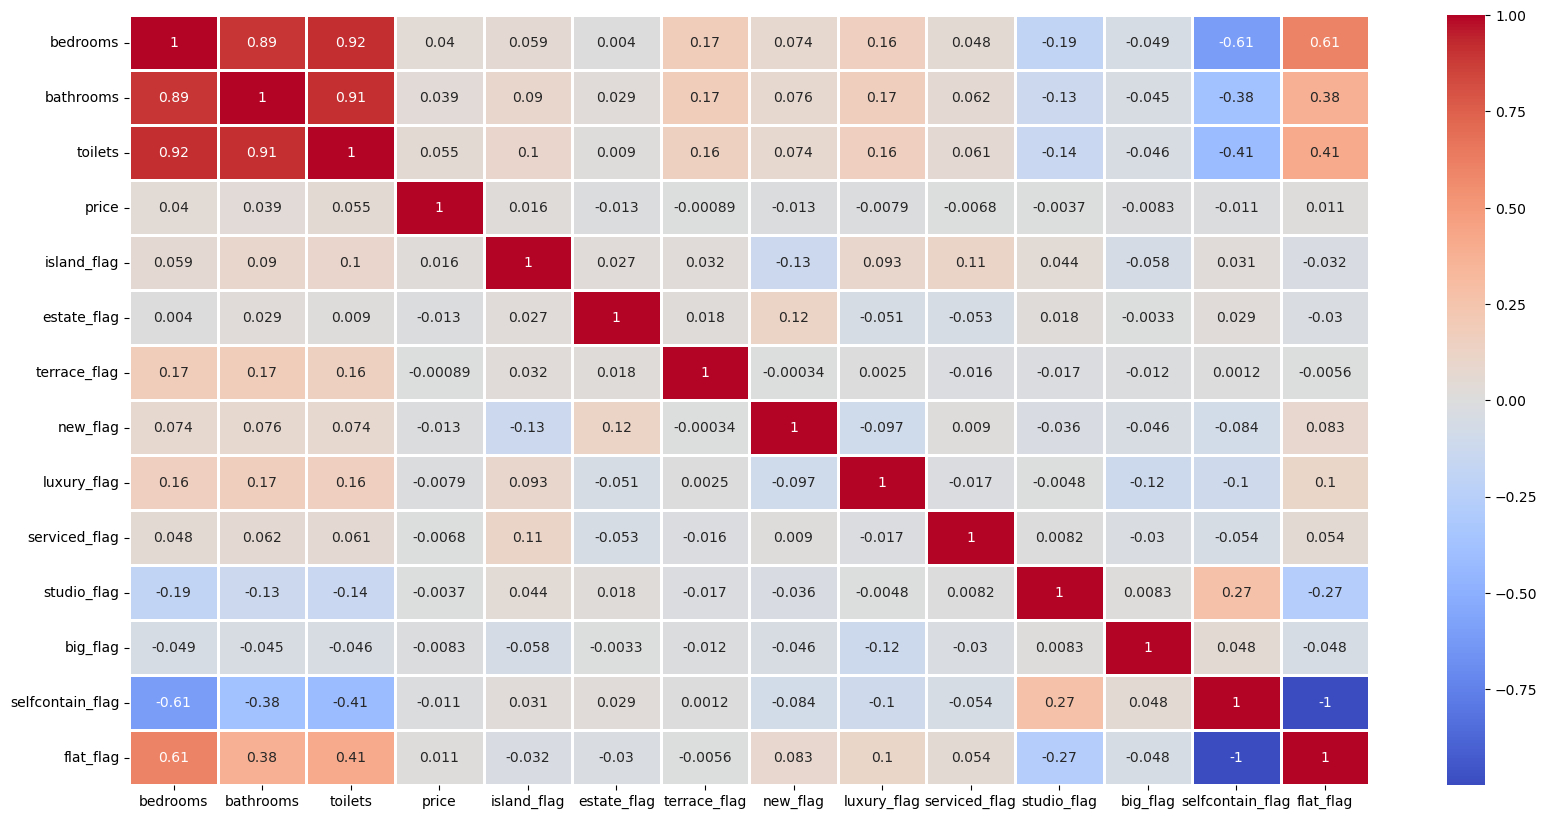

In [21]:
# Correlation coefficients between features
plt.figure(figsize=(20, 10))
sns.heatmap(prop2.corr(),cmap='coolwarm',linewidths=2.0, annot=True);

In [22]:
def unique_(data, cols):
    for each in cols:
        x = data[each].unique()
        print("Unique values in", each, "column",x)

In [23]:
unique_(prop2, ['bedrooms', 'bathrooms', 'toilets'])

Unique values in bedrooms column [3 2 1 4 0 5 6 8 7]
Unique values in bathrooms column [3 2 1 4 5 6 8 7]
Unique values in toilets column [4 3 1 2 5 6 8 7 9]


In [24]:
city_stats = prop2.groupby('city')['city'].agg('count').sort_values(ascending=False)
city_stats

city
Lekki                2381
Ajah                 1221
Ikoyi                1113
Victoria Island       419
Yaba                  199
Ikeja                 189
Surulere              153
Magodo                107
Gbagada               104
Ikorodu                96
Isolo                  78
Shomolu                68
Ojodu                  47
Ketu                   44
Maryland               43
Ogudu                  41
Ipaja                  40
Isheri North           39
Agege                  35
Odofin                 23
Alimosho               17
Ayobo                  17
Eko Atlantic City      13
Ikotun                 11
Epe                    10
Ojo                    10
Ilupeju                 9
Ifako-Ijaiye            6
Kosofe                  4
Ojota                   4
Lagos Island            4
Oshodi                  3
Apapa                   3
Mushin                  2
Ijaiye                  2
Ijede                   2
Idimu                   1
Name: city, dtype: int64

### Removing Outliers

In [25]:
prop2.groupby('city')['price'].max().sort_values(ascending=False)

city
Ikoyi                15000000000
Victoria Island       8000000000
Lekki                 3000000000
Ojo                    250000000
Ikeja                   80000000
Magodo                  55000000
Eko Atlantic City       30000000
Ajah                    18000000
Surulere                10000000
Ilupeju                  9200000
Maryland                 7000000
Gbagada                  4800000
Apapa                    4000000
Ogudu                    3600000
Yaba                     3500000
Shomolu                  3000000
Isheri North             3000000
Agege                    2500000
Ojodu                    2500000
Isolo                    2500000
Ketu                     2500000
Odofin                   2200000
Lagos Island             1500000
Ijaiye                   1500000
Alimosho                 1500000
Ifako-Ijaiye             1300000
Ipaja                    1200000
Ikorodu                  1100000
Oshodi                   1000000
Mushin                    850000
Ikotu

In [26]:
prop2.shape

(6558, 15)

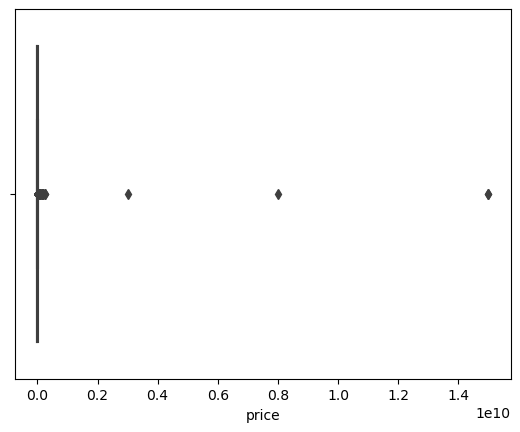

In [27]:
sns.boxplot(x='price', data=prop2);

There are outliers in the price column. let's check the price at the 95th percentile and cut off anything greater than the value we get

In [28]:
prop2.query("price<100000")

,bedrooms,bathrooms,toilets,city,price,island_flag,estate_flag,terrace_flag,new_flag,luxury_flag,serviced_flag,studio_flag,big_flag,selfcontain_flag,flat_flag
309,0,1,1,Kosofe,80000,0,0,0,0,0,0,0,0,1,0
429,1,1,1,Ikorodu,80000,0,0,0,0,0,0,0,0,0,1
1273,0,1,1,Shomolu,60000,0,0,0,0,0,0,0,0,1,0
5270,1,1,1,Ikorodu,80000,0,1,0,0,0,0,0,0,0,1
6317,0,1,1,Ikorodu,84000,0,0,0,0,0,0,0,0,1,0


In [29]:
prop2.query("city=='Shomolu'")['price'].describe()

count    6.800000e+01
mean     8.242647e+05
std      5.694861e+05
min      6.000000e+04
25%      4.075000e+05
50%      6.250000e+05
75%      1.125000e+06
max      3.000000e+06
Name: price, dtype: float64

In [30]:
prop2['price'].describe()

count    6.558000e+03
mean     1.067483e+07
std      2.823874e+08
min      6.000000e+04
25%      1.000000e+06
50%      2.000000e+06
75%      5.000000e+06
max      1.500000e+10
Name: price, dtype: float64

In [31]:
prop2['price'].quantile(0.95)

15000000.0

<AxesSubplot:xlabel='price'>

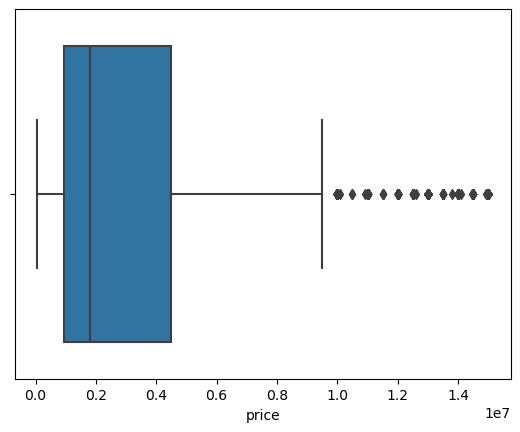

In [32]:
sns.boxplot(x=prop2[prop2['price']<=prop2['price'].quantile(0.95)]['price'])

In [33]:
prop3 = prop2[~(prop2['price']>prop2['price'].quantile(0.95))]

In [34]:
prop3.shape

(6327, 15)

<AxesSubplot:xlabel='price', ylabel='Count'>

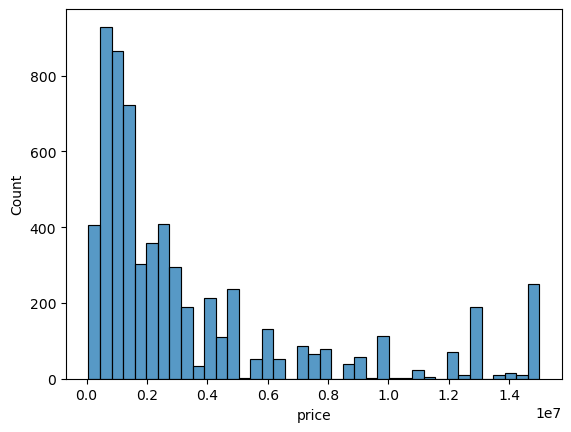

In [35]:
sns.histplot(x=prop3['price'])

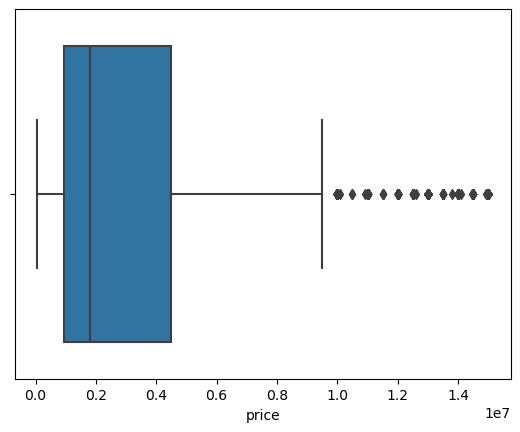

In [36]:
sns.boxplot(x='price', data=prop3);

Looking at the boxplot, we still have some outliers in pur price column. However, we will continue with our preprocessing on other columns and build our first model iteration

Let's do the same for other columns such as **Bathrooms, Bedrooms and Toilets**


### Bathrooms

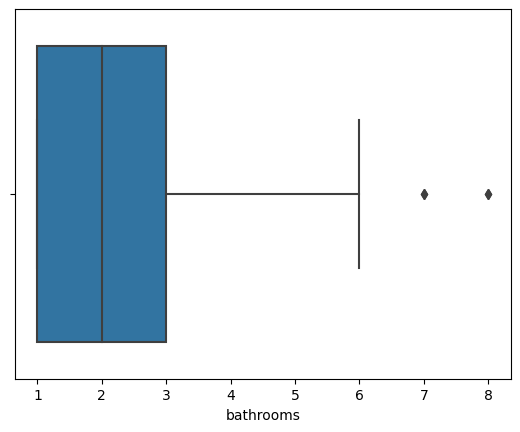

In [37]:
sns.boxplot(x='bathrooms', data=prop3);

In [38]:
prop3['bathrooms'].describe()

count    6327.000000
mean        2.207839
std         1.049946
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: bathrooms, dtype: float64

In [39]:
prop3['bathrooms'].quantile(0.999)

6.0

<AxesSubplot:xlabel='bathrooms'>

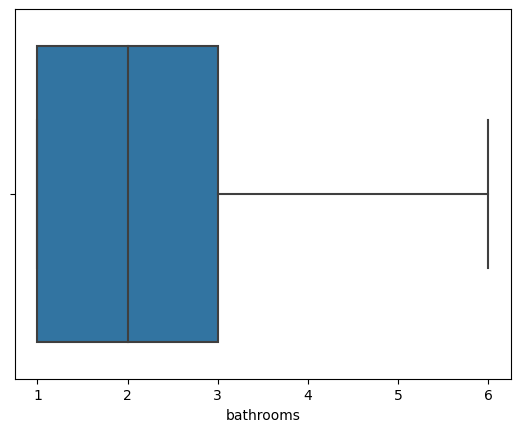

In [40]:
sns.boxplot(x=prop2[prop2['bathrooms']<=prop2['bathrooms'].quantile(0.999)]['bathrooms'])

In [41]:
prop3[prop3['bathrooms'] >prop3['bathrooms'].quantile(0.999)]

,bedrooms,bathrooms,toilets,city,price,island_flag,estate_flag,terrace_flag,new_flag,luxury_flag,serviced_flag,studio_flag,big_flag,selfcontain_flag,flat_flag
1392,3,8,4,Lekki,6000000,1,0,0,0,0,0,0,0,0,1
2322,6,7,7,Ogudu,120000,0,0,1,0,1,0,0,0,0,1
2687,8,8,9,Ikoyi,13500000,1,0,0,0,0,0,0,0,0,1
6092,5,7,7,Lekki,8000000,1,1,1,0,1,0,0,0,0,1


There about 11 observations where bathrooms value is greater than 5 i.e the value at 99th percentile. Removing the observations in the next cells

In [42]:
prop4 = prop3[~(prop3['bathrooms'] >prop3['bathrooms'].quantile(0.999))]

In [43]:
prop4[prop4['bathrooms']==4].sort_values(by='price',ascending=False)[:10]

,bedrooms,bathrooms,toilets,city,price,island_flag,estate_flag,terrace_flag,new_flag,luxury_flag,serviced_flag,studio_flag,big_flag,selfcontain_flag,flat_flag
5175,4,4,5,Ikoyi,15000000,1,0,0,0,1,0,0,0,0,1
5246,4,4,5,Ikoyi,15000000,1,0,2,1,0,1,0,0,0,1
773,4,4,5,Ikoyi,15000000,1,0,0,1,0,0,0,0,0,1
2582,4,4,5,Ikoyi,15000000,1,0,0,0,1,1,0,0,0,1
2665,3,4,4,Ikoyi,15000000,1,0,0,1,1,0,0,0,0,1
2668,3,4,5,Ikoyi,15000000,1,1,0,0,1,0,0,0,0,1
552,3,4,4,Victoria Island,15000000,1,0,0,0,0,0,0,0,0,1
913,4,4,5,Ikoyi,15000000,1,0,0,0,1,0,0,0,0,1
4468,4,4,5,Ikoyi,15000000,1,0,0,0,1,0,0,0,0,1
2462,4,4,5,Ikoyi,15000000,1,0,0,0,1,0,0,0,0,1


Do we have duplicates entries? Let's find out in the next cell by taking a sample of the dataframe above

In [44]:
prop.loc[[5175,5246,773,2582]]

,page,title,description,bedrooms,bathrooms,toilets,garage,location,city,price,island_flag,estate_flag,terrace_flag,new_flag,luxury_flag,serviced_flag,studio_flag,big_flag,selfcontain_flag,flat_flag
5175,247,Luxury Finished 4 Bedroom Maisonette,4 bedroom flat / apartment for rent,4,4,5,0,"Ikoyi, Lagos",Ikoyi,15000000,1,0,0,0,1,0,0,0,0,1
5246,250,Newly Built Serviced 4 Bedrooms Terraced Duple...,4 bedroom flat / apartment for rent,4,4,5,0,"Banana Island, Banana Island, Ikoyi, Lagos",Ikoyi,15000000,1,0,2,1,0,1,0,0,0,1
773,37,Newly Built 4 Bedroom Maisonette On 2 Floors +bq,4 bedroom flat / apartment for rent,4,4,5,2,"Old Ikoyi, Ikoyi, Lagos",Ikoyi,15000000,1,0,0,1,0,0,0,0,0,1
2582,123,8 Units Of Serviced 4 Bedroom Luxury Flats Wit...,4 bedroom flat / apartment for rent,4,4,5,4,"Off First Avenue, Ikoyi, Lagos",Ikoyi,15000000,1,0,0,0,1,1,0,0,0,1


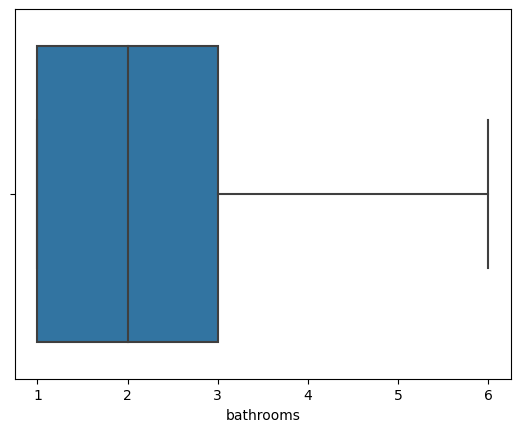

In [45]:
sns.boxplot(x='bathrooms', data=prop4);

### Bedrooms

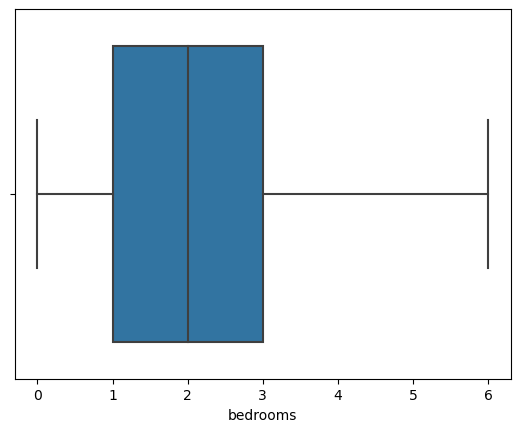

In [46]:
sns.boxplot(x='bedrooms',data=prop4);

Interesting! No outliers detected

### Toilets

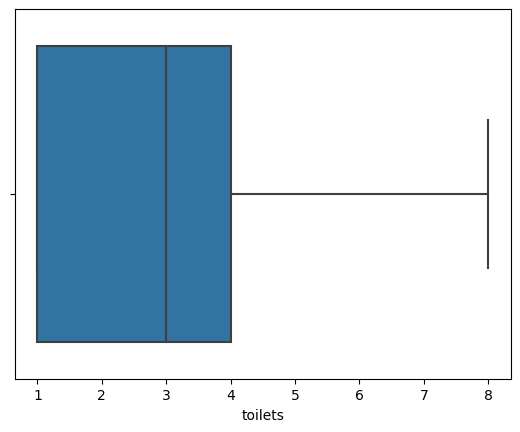

In [47]:
sns.boxplot(x='toilets',data=prop4);

In [48]:
prop4['toilets'].describe()

count    6323.000000
mean        2.746165
std         1.348579
min         1.000000
25%         1.000000
50%         3.000000
75%         4.000000
max         8.000000
Name: toilets, dtype: float64

In [49]:
prop4['toilets'].quantile(0.95)

5.0

In [50]:
prop4[prop4['toilets']>prop4['toilets'].quantile(0.95)]

,bedrooms,bathrooms,toilets,city,price,island_flag,estate_flag,terrace_flag,new_flag,luxury_flag,serviced_flag,studio_flag,big_flag,selfcontain_flag,flat_flag
28,5,5,6,Lekki,7500000,1,0,0,1,0,0,0,0,0,1
100,5,5,6,Lekki,7000000,1,0,2,0,1,0,0,0,0,1
931,5,5,6,Lekki,6000000,1,0,1,0,0,1,0,0,0,1
1466,5,5,6,Victoria Island,8500000,1,0,2,0,0,0,0,0,0,1
1483,5,5,6,Ajah,3000000,1,1,1,0,0,0,0,0,0,1
1663,4,4,6,Victoria Island,8500000,1,0,0,0,0,0,0,0,0,1
1733,0,1,8,Lekki,7200000,1,0,0,1,0,0,0,1,1,0
1859,3,5,6,Gbagada,3000000,0,0,0,0,0,1,0,0,0,1
2138,5,5,6,Lekki,6000000,1,0,2,0,0,0,0,1,0,1
2145,5,6,6,Ajah,3000000,1,0,2,1,1,0,0,0,0,1


looking at the dataframe above, **index 1733** has **0** number of bedrooms which indicates a self-contain apartment but has **8** toilets which is ridiculous. Let's create a subset of bedroooms with 0 rooms and check further if there other rows with such observations in both the bathrooms and toilets column

In [51]:
self_contain = prop4[(prop4['bedrooms']==0)]

In [52]:
self_contain[self_contain['toilets']>1]

,bedrooms,bathrooms,toilets,city,price,island_flag,estate_flag,terrace_flag,new_flag,luxury_flag,serviced_flag,studio_flag,big_flag,selfcontain_flag,flat_flag
244,0,1,2,Lekki,1200000,1,0,0,1,0,0,0,1,1,0
686,0,1,4,Lekki,750000,1,0,0,0,0,0,0,0,1,0
984,0,1,2,Lekki,700000,1,0,0,0,0,0,0,1,1,0
1675,0,1,4,Lekki,3500000,1,0,1,0,0,0,0,0,1,0
1733,0,1,8,Lekki,7200000,1,0,0,1,0,0,0,1,1,0
4523,0,1,2,Lekki,1500000,1,0,0,0,0,1,0,1,1,0
4929,0,1,3,Lekki,1700000,1,0,0,0,0,0,0,0,1,0
5336,0,1,2,Lekki,400000,1,0,0,1,0,0,1,0,1,0
5348,0,1,2,Victoria Island,1500000,1,0,0,0,1,0,0,0,1,0
5401,0,1,2,Shomolu,400000,0,0,0,1,0,0,0,0,1,0


In [53]:
self_contain['toilets'].unique()

array([1, 2, 4, 8, 3], dtype=int64)

In [54]:
prop4.loc[(prop4['bedrooms']==0) & (prop4['toilets']>2)]

,bedrooms,bathrooms,toilets,city,price,island_flag,estate_flag,terrace_flag,new_flag,luxury_flag,serviced_flag,studio_flag,big_flag,selfcontain_flag,flat_flag
686,0,1,4,Lekki,750000,1,0,0,0,0,0,0,0,1,0
1675,0,1,4,Lekki,3500000,1,0,1,0,0,0,0,0,1,0
1733,0,1,8,Lekki,7200000,1,0,0,1,0,0,0,1,1,0
4929,0,1,3,Lekki,1700000,1,0,0,0,0,0,0,0,1,0


We will now replace these observations above in the **toilets** column with **1** which is the minimum number of bedrooms a self-contain should have

In [55]:
prop4.loc[((prop4['bedrooms']==0) & (prop4['toilets']>2)), 'toilets'] = 1

In [56]:
# check
prop4.loc[(prop4['bedrooms']==0) & (prop4['toilets']>2)]

,bedrooms,bathrooms,toilets,city,price,island_flag,estate_flag,terrace_flag,new_flag,luxury_flag,serviced_flag,studio_flag,big_flag,selfcontain_flag,flat_flag


In [57]:
def create_boxplot(data,col):
    for i in range(len(col)):
        plt.figure()
        plot = sns.boxplot(x=data[col[i]])
        plt.title(col[i])
        plt.show()

In [58]:
cols = ['bedrooms', 'bathrooms', 'toilets']

In [59]:
data = prop4.loc[:,['bedrooms', 'bathrooms', 'toilets']]

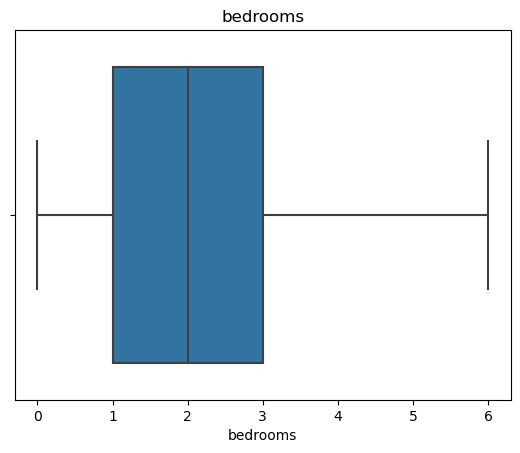

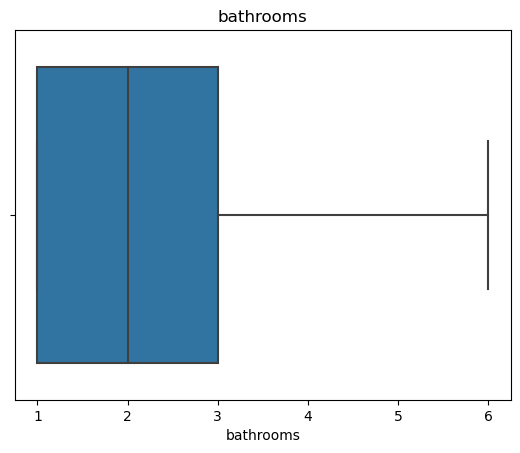

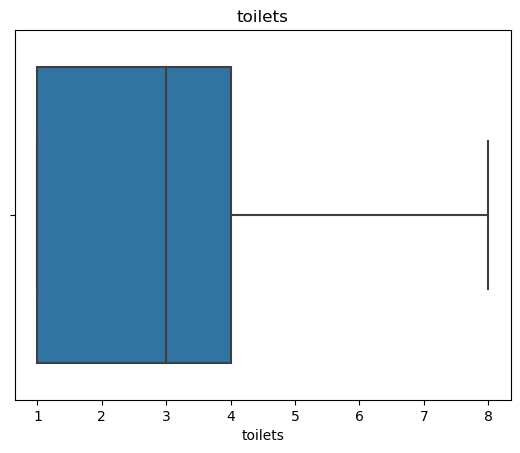

In [60]:
create_boxplot(data,data.columns)

### Check if number of bathrooms is greater than bedrooms and also if number of toilets is less than bathrooms

In [61]:
prop4.shape

(6323, 15)

In [62]:
prop4[(prop4['bathrooms']>prop4['bedrooms']+2)]

,bedrooms,bathrooms,toilets,city,price,island_flag,estate_flag,terrace_flag,new_flag,luxury_flag,serviced_flag,studio_flag,big_flag,selfcontain_flag,flat_flag
568,2,5,3,Ikoyi,8500000,1,0,0,0,0,0,0,0,0,1
719,3,6,3,Surulere,2000000,0,0,0,0,0,0,0,1,0,1
880,2,5,3,Lekki,7000000,1,0,0,0,1,1,0,0,0,1
2064,2,5,3,Lekki,850000,1,1,0,0,0,0,0,0,0,1
3102,2,5,3,Ajah,1700000,1,0,0,0,0,0,0,0,0,1
3286,2,5,3,Ajah,1100000,1,0,0,0,1,0,0,0,0,1
3941,2,5,3,Ajah,1300000,1,0,0,0,0,0,0,1,0,1
5824,3,6,4,Victoria Island,7500000,1,0,0,0,0,1,0,0,0,1


In [63]:
prop5 = prop4[~(prop4['bathrooms']>prop4['bedrooms']+2)]
prop5.shape

(6315, 15)

In [64]:
prop5[(prop5['bathrooms']>prop5['toilets'])]

,bedrooms,bathrooms,toilets,city,price,island_flag,estate_flag,terrace_flag,new_flag,luxury_flag,serviced_flag,studio_flag,big_flag,selfcontain_flag,flat_flag
27,2,4,3,Ajah,1400000,1,0,0,0,2,0,0,0,0,1
34,4,4,3,Lekki,10000000,1,0,1,0,0,0,0,0,0,1
102,2,3,2,Ikoyi,8000000,1,0,0,0,1,0,0,0,0,1
112,4,5,4,Ikoyi,12000000,1,0,0,0,1,0,0,0,0,1
184,2,2,1,Ajah,1100000,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6029,2,3,2,Ikoyi,11500000,1,0,0,0,0,0,0,0,0,1
6162,2,3,2,Ajah,900000,1,1,0,0,0,0,0,0,0,1
6170,3,4,3,Ikoyi,10000000,1,0,0,0,1,0,0,0,0,1
6260,3,3,2,Surulere,1500000,0,0,0,0,0,0,0,0,0,1


In [65]:
prop6 = prop5[~(prop5['bathrooms']>prop5['toilets'])]
prop6.shape

(6252, 15)

In [66]:
prop6[(prop6['toilets'] >prop6['bedrooms']+2)]

,bedrooms,bathrooms,toilets,city,price,island_flag,estate_flag,terrace_flag,new_flag,luxury_flag,serviced_flag,studio_flag,big_flag,selfcontain_flag,flat_flag
1859,3,5,6,Gbagada,3000000,0,0,0,0,0,1,0,0,0,1


In [67]:
prop7 = prop6[~(prop6['toilets'] >prop6['bedrooms']+2)]
prop7.shape

(6251, 15)

In [68]:
prop7.head()

,bedrooms,bathrooms,toilets,city,price,island_flag,estate_flag,terrace_flag,new_flag,luxury_flag,serviced_flag,studio_flag,big_flag,selfcontain_flag,flat_flag
0,3,3,4,Ikoyi,15000000,1,0,0,0,2,0,0,0,0,1
1,2,2,3,Victoria Island,3500000,1,0,0,0,0,0,0,0,0,1
2,3,3,3,Lekki,4000000,1,0,0,0,1,1,0,0,0,1
3,1,1,1,Ajah,1000000,1,0,0,0,0,0,0,0,0,1
4,4,3,4,Ikoyi,12000000,1,0,0,0,1,0,0,0,0,1


In [69]:
len(self_contain)

619

In [70]:
prop7['price'].median()

1800000.0

In [71]:
prop7[prop7['bathrooms']>prop7['bedrooms']]

,bedrooms,bathrooms,toilets,city,price,island_flag,estate_flag,terrace_flag,new_flag,luxury_flag,serviced_flag,studio_flag,big_flag,selfcontain_flag,flat_flag
24,0,1,1,Ajah,500000,1,1,0,0,0,0,0,0,1,0
38,0,1,1,Lekki,500000,1,0,0,0,0,0,0,0,1,0
46,0,1,1,Ikorodu,160000,0,1,0,0,1,0,0,0,1,0
67,0,1,1,Ajah,400000,1,1,0,1,0,0,0,0,1,0
83,0,1,1,Lekki,1400000,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6556,0,1,1,Lekki,1800000,1,0,0,0,0,0,1,0,1,0
6566,0,1,1,Lekki,250000,1,0,0,1,1,0,0,0,1,0
6568,0,1,1,Lekki,800000,1,0,0,0,1,0,0,0,1,0
6570,0,1,1,Lekki,300000,1,1,0,1,0,0,0,0,1,0


### Get dummies of the city columns

In [72]:
dummies = pd.get_dummies(prop7['city'], drop_first=True)
dummies.head()

,Ajah,Alimosho,Apapa,Ayobo,Eko Atlantic City,Epe,Gbagada,Idimu,Ifako-Ijaiye,Ijaiye,...,Odofin,Ogudu,Ojo,Ojodu,Ojota,Oshodi,Shomolu,Surulere,Victoria Island,Yaba
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
dummies.shape

(6251, 36)

In [74]:
prop8 = pd.concat([prop7, dummies], axis=1).drop('city',axis=1)
prop8.head()

,bedrooms,bathrooms,toilets,price,island_flag,estate_flag,terrace_flag,new_flag,luxury_flag,serviced_flag,...,Odofin,Ogudu,Ojo,Ojodu,Ojota,Oshodi,Shomolu,Surulere,Victoria Island,Yaba
0,3,3,4,15000000,1,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,2,2,3,3500000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,3,3,4000000,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1000000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,3,4,12000000,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
prop8.shape

(6251, 50)

## Model Building

In [76]:
seed = 42
np.random.seed(seed)

In [77]:
X = prop8.drop(['price'], axis=1)
y = prop8['price']

In [78]:
prop8.columns

Index(['bedrooms', 'bathrooms', 'toilets', 'price', 'island_flag',
       'estate_flag', 'terrace_flag', 'new_flag', 'luxury_flag',
       'serviced_flag', 'studio_flag', 'big_flag', 'selfcontain_flag',
       'flat_flag', 'Ajah', 'Alimosho', 'Apapa', 'Ayobo', 'Eko Atlantic City',
       'Epe', 'Gbagada', 'Idimu', 'Ifako-Ijaiye', 'Ijaiye', 'Ijede', 'Ikeja',
       'Ikorodu', 'Ikotun', 'Ikoyi', 'Ilupeju', 'Ipaja', 'Isheri North',
       'Isolo', 'Ketu', 'Kosofe', 'Lagos Island', 'Lekki', 'Magodo',
       'Maryland', 'Mushin', 'Odofin', 'Ogudu', 'Ojo', 'Ojodu', 'Ojota',
       'Oshodi', 'Shomolu', 'Surulere', 'Victoria Island', 'Yaba'],
      dtype='object')

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

In [80]:
def model_performance(model):
    results = []
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    mean_abs_error = mean_absolute_error(y_test, y_pred)
    mean_sqr_error = mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    r2score = r2_score(y_test, y_pred)
    results.append({
            'train_score':train_score,
            'test_score':test_score,
            'mean_absolute_error':mean_abs_error,
            'mean_squared_error':mean_sqr_error,
            'RMSE':rmse,
            'r2_score':r2score})
    return pd.DataFrame(results, columns=['train_score','test_score','mean_absolute_error','mean_squared_error','RMSE','r2_score'])

In [81]:
# Linear Regression(baseline)
lr = LinearRegression()
model_performance(lr)

,train_score,test_score,mean_absolute_error,mean_squared_error,RMSE,r2_score
0,0.800483,-1.160748e+13,3.808252e+11,1.814287e+26,1.346955e+13,-1.160748e+13


# Model Selection

In [82]:
 def model_selection():
    models = {
        'linear_regression':{
            'model':LinearRegression()
        },
        'random_forest':{
            'model':RandomForestRegressor()
        },
        'decision_tree':{
            'model':DecisionTreeRegressor()
        },
        'extra_tree':{
            'model':ExtraTreesRegressor()
        },
        'gradient_boost':{
            'model':GradientBoostingRegressor()
        },
        'lasso':{
            'model': Lasso()
        },
        'elsaticnet':{
            'model': ElasticNet()
        },
        'Kneigbors':{
            'model': KNeighborsRegressor()
        },
        'catboost':{
            'model':CatBoostRegressor(verbose=False)
        },
        'ridge':{
            'model': Ridge()
        }
    }

    scores = []
    for model_name, config in models.items():
        start = time.time()
        config['model'].fit(X_train, y_train)
        y_pred = config['model'].predict(X_test) 
        train_score = config['model'].score(X_train, y_train)
        test_score = config['model'].score(X_test, y_test)
        mean_abs_error = mean_absolute_error(y_test, y_pred)
        mean_sqr_error = mean_squared_error(y_test, y_pred)
        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
        r2score = r2_score(y_test, y_pred)
        end = time.time()
        elasped_time = end - start
        print(model_name)
        scores.append({
            'model': model_name,
            'train_score':train_score,
            'test_score':test_score,
            'mean_absolute_error':mean_abs_error,
            'mean_squared_error':mean_sqr_error,
            'RMSE':rmse,
            'r2_score':r2score,
            'time_taken':elasped_time})

    return pd.DataFrame(scores,columns=['model','train_score','test_score',
                                        'mean_absolute_error','mean_squared_error','RMSE','r2_score','time_taken'])
result = model_selection()

linear_regression
random_forest
decision_tree
extra_tree
gradient_boost
lasso
elsaticnet
Kneigbors
catboost
ridge


In [83]:
result.sort_values(by='mean_absolute_error')

,model,train_score,test_score,mean_absolute_error,mean_squared_error,RMSE,r2_score,time_taken
8,catboost,0.880009,8.584867e-01,8.375418e+05,2.211900e+12,1.487246e+06,8.584867e-01,4.625007
1,random_forest,0.890502,8.455565e-01,8.652445e+05,2.414003e+12,1.553706e+06,8.455565e-01,1.640621
4,gradient_boost,0.860555,8.592627e-01,8.690219e+05,2.199771e+12,1.483162e+06,8.592627e-01,0.353649
7,Kneigbors,0.865473,8.417963e-01,8.707412e+05,2.472776e+12,1.572506e+06,8.417963e-01,1.682004
3,extra_tree,0.894755,8.361568e-01,8.813697e+05,2.560923e+12,1.600288e+06,8.361568e-01,1.521028
2,decision_tree,0.894755,8.266739e-01,9.002729e+05,2.709144e+12,1.645948e+06,8.266739e-01,0.043962
5,lasso,0.804461,8.091735e-01,1.170642e+06,2.982681e+12,1.727044e+06,8.091735e-01,0.321999
9,ridge,0.803986,8.091766e-01,1.171101e+06,2.982632e+12,1.727030e+06,8.091766e-01,0.049999
6,elsaticnet,0.526331,5.508472e-01,1.792502e+06,7.020405e+12,2.649605e+06,5.508472e-01,0.033998
0,linear_regression,0.800483,-1.160748e+13,3.808252e+11,1.814287e+26,1.346955e+13,-1.160748e+13,0.029999


## Hyperparamater tunning

### Using Grid Search CV to find the best parameters

In [86]:
def hyperparameter_tunning(X,y):
    model = {
        'catboost':{
            'model':CatBoostRegressor(verbose=False,random_state=seed),
            'params':{
                'iterations':[1000,1500],
                'learning_rate':[0.01,0.1],
                'depth':[5,10,15,20]
            }
        }
    }
    for model_name, config in model.items():
        grid = GridSearchCV(config['model'], config['params'],return_train_score=True,scoring='neg_mean_absolute_error')
        grid.fit(X,y)
        
    return pd.DataFrame(grid.cv_results_,columns=['mean_test_score','mean_train_score','params',\
                                                  'rank_test_score']).sort_values(by='rank_test_score')

In [87]:
results = hyperparameter_tunning(X_train,y_train)

In [89]:
results['params'][6]

{'depth': 10, 'iterations': 1500, 'learning_rate': 0.01}

In [92]:
# Cross validation function
def model_evaluation(model, X, y):
    kf = KFold(n_splits=5, random_state=seed, shuffle=True)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=kf, error_score='raise')
    return scores

In [119]:
catboost = CatBoostRegressor(depth=10, iterations=1500, learning_rate=0.01, random_state=seed, verbose=False)
model_performance(catboost)

,train_score,test_score,mean_absolute_error,mean_squared_error,RMSE,r2_score
0,0.877408,0.859421,840220.130642,2.197294e+12,1.482327e+06,0.859421


In [96]:
model_evaluation(catboost, X, y).mean()

-856095.2205241027

In [130]:
catboost = CatBoostRegressor(depth=10, iterations=1000, learning_rate=0.01, random_state=seed, verbose=False)
model_performance(catboost)

,train_score,test_score,mean_absolute_error,mean_squared_error,RMSE,r2_score
0,0.872308,0.860147,846465.135981,2.185951e+12,1478496.04,0.860147


In [131]:
predictions = catboost.predict(X_test)

In [132]:
resultss = pd.DataFrame(dict(actual=y_test,predicted=predictions))

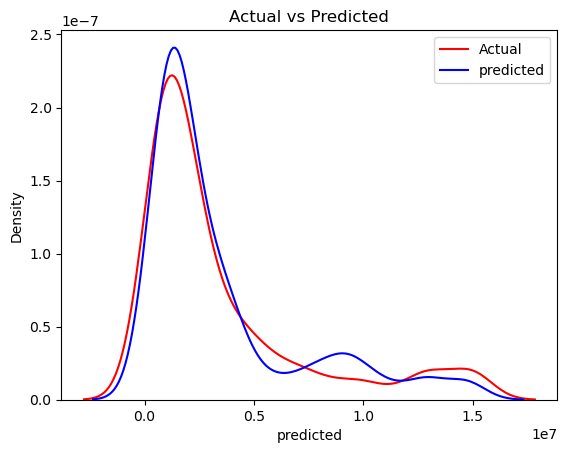

In [133]:
ax1 = sns.distplot(resultss['actual'], hist=False, color="r", label="Actual")
sns.distplot(resultss['predicted'], hist=False, color="b", label="predicted" , ax=ax1)
plt.title('Actual vs Predicted')
plt.legend();

### Let's predict prices

In [134]:
def predict_price(city,bedroom,bathroom,toilet,estate=False,terraced=False,self_contain=False,flat=False):
    loc_index = np.where(X.columns==city)[0][0]
    
    x = np.zeros(len(X.columns))
    x[0] = bedroom
    x[1] = bathroom
    x[2] = toilet
    x[4] = estate
    x[5] = terraced
    x[11] = self_contain
    x[12] = flat
    if loc_index >= 0 :
        x[loc_index] = 1
        
    return catboost.predict([x])[0]

In [135]:
predict_price('Lekki',3,3,4,estate=False, terraced=True)

3330593.4303387543

In [136]:
predict_price('Lekki',3,3,4,False,False,True) 

3044386.257634652

In [137]:
predict_price('Lekki',0,1,1,True) 

785632.0824237075

In [138]:
predict_price('Shomolu',0,1,1,estate=True,self_contain=True)

387775.87099143304

In [139]:
predict_price('Shomolu',2,1,2,estate=True, flat=True)

953899.207841876

In [140]:
predict_price('Yaba',0,1,1)

392273.63165353565

In [141]:
prop[prop['city']=='Shomolu']['price'].mean()

824264.7058823529

### Exporting the model to disk

In [142]:
import pickle
with open('Lagos_properties_price_model.pickle','wb') as f:
    pickle.dump(catboost, f)